In [200]:
from scipy.sparse.linalg import splu, factorized
from scipy.linalg import lu_factor, lu_solve
import numpy as np
np.set_printoptions(precision=4) # Print few decimal places
np.set_printoptions(suppress=True) # Suppress scientific notation
import cvxpy as cp
import pandas as pd
from numpy.linalg import cholesky as llt
import matplotlib.pyplot as plt
import scipy.stats as stats
import time

Generating Data Function

In [201]:
def generate_randn_data(m,n):
    w = np.random.randn(n)
    x = np.maximum(w, 0)
    lambd = np.maximum(-w, 0)
    A = np.random.randn(m,n)
    nu = np.random.randn(m)
    b = A @ x
    
    c = - A.T @ nu + lambd
    return A, b, c, x, lambd, nu

Testing CVXPY and Formulation

In [202]:
np.random.seed(142)
# NOTE
# Test case and the formulation for the splitting
n = 10
m = 10
A_, b_, c_, x_, lambd_, nu_ = generate_randn_data(m, n)
u = np.random.uniform(np.max(x_), 5*np.max(x_), n) 
l = -u

# NOTE
# TESTING

# u_ = np.copy(u)
# l_ = np.copy(l)
# indices_u = np.random.choice(n, size=int(10/2), replace=False)
# indices_l = np.random.choice(n, size=int(10/2), replace=False)
# for i in indices_u:
#     u_[i] = x_[i]
# for i in indices_l:
#     l_[i] = x_[i]

# x_cvxpy = cp.Variable(x_.shape)
# objective = cp.Minimize(c_.T @ x_cvxpy)
# constraints = [A_ @ x_cvxpy == b_, x_cvxpy >= l_, x_cvxpy <= u_]
# problem = cp.Problem(objective, constraints)
# problem.solve()
# print(problem.status)
# print("cvxpy value =", c_.T @ x_cvxpy.value)
# print("actual value =", c_.T @ x_)
# print(u_ - x_cvxpy.value)
# print(x_cvxpy.value - l_)



x_cvxpy = cp.Variable(x_.shape)
objective = cp.Minimize(c_.T @ x_cvxpy)
constraints = [A_ @ x_cvxpy == b_, x_cvxpy >= l, x_cvxpy <= u]
problem = cp.Problem(objective, constraints)
problem.solve()
print(problem.status)
print("cvxpy value =", c_.T @ x_cvxpy.value)
print("actual value =", c_.T @ x_)


x_cvxpy_u = cp.Variable(int(0.5*n))
x_cvxpy_l = cp.Variable(n-int(0.5*n))
objective = cp.Minimize(c_[:int(0.5*n)].T@x_cvxpy_u + c_[int(0.5*n):].T@x_cvxpy_l)
constraints = [A_[:,:int(0.5*n)]@x_cvxpy_u + A_[:,int(0.5*n):]@x_cvxpy_l == b_,
               x_cvxpy_u >= l[:int(0.5*n)], x_cvxpy_l >= l[int(0.5*n):],
               x_cvxpy_u <= u[:int(0.5*n)], x_cvxpy_l <= u[int(0.5*n):]]
problem = cp.Problem(objective, constraints)
problem.solve()
print(problem.status)
print("cvxpy value =", c_[:int(0.5*n)].T@x_cvxpy_u.value + c_[int(0.5*n):].T@x_cvxpy_l.value)
print("actual value =", c_.T @ x_)


optimal
cvxpy value = 7.5518269074962
actual value = 7.5518269074962
optimal
cvxpy value = 7.5518269074962
actual value = 7.5518269074962


Utility Functions

In [203]:
# NOTE
# I implemented a rudementary version for simplicity and to first make sure that this worked

def ADMM(c1, c2, U, V, q, u, l, xu, xv, y, nu):
    var1 = cp.Variable(xu.shape[0])
    constraint1 = [var1 <= u[:xu.shape[0]], l[:xu.shape[0]] <= var1]
    prob_1 = cp.Problem(cp.Minimize(c1 @ var1 + (nu/2) * cp.sum_squares((U @ var1 + V @ xv - q) - (1/nu) * y)), constraint1)
    prob_1 = cp.Problem(cp.Minimize(c1 @ var1 + (nu/2) * cp.sum_squares((U @ var1 + V @ xv - q) + y)), constraint1)
    prob_1.solve()
    
    xu_next = var1.value
    
    var_2 = cp.Variable(xv.shape[0])
    constraint2 = [var_2 <= u[xv.shape[0]:], l[xv.shape[0]:] <= var_2]
    prob_2 = cp.Problem(cp.Minimize(c2 @ xv + (nu/2) * cp.sum_squares((U @ xu_next + V @ var_2 - q) - (1/nu) * y)), constraint2)
    prob_2 = cp.Problem(cp.Minimize(c2 @ xv + (nu/2) * cp.sum_squares((U @ xu_next + V @ var_2 - q) + y)), constraint2)
    prob_2.solve()
    
    xv_next = var_2.value
    
    y_next = y - nu * (U @ xu_next + V @ xv_next - q)
    y_next = y + U @ xu_next + V @ xv_next - q
    z_hat_next = [xu_next, xv_next, y - nu * (U @ xu_next + V @ xv - q)]
    z_next = [xu_next, xv_next, y_next]
    
    return z_hat_next, z_next


def KKT_error(nu, A, b, K, c, lam, lam_plus, lam_minus, q, l, u, x, y, U, V, z, z_prev):
    
    norm1 = np.linalg.norm(A@x - b, 2) ** 2
    
    # Normal dual residual
    norm2 = np.linalg.norm(c - K.T @ y - lam, 2) ** 2
    # ADMM dual residual
    norm2 = np.linalg.norm(nu*U.T@V@(z - z_prev), 2) ** 2
    
    KKT = np.sqrt(nu**2 * norm1 + (1/(nu**2)) * norm2 + (q.T@y + l.T@lam_plus - u.T@lam_minus - c.T@x) ** 2)
    
    return KKT


def lam_comp(A, y, xu, xv, u, l, c):
    lam_pos = np.ones(xu.shape[0] + xv.shape[0])
    lam_neg = np.ones(xu.shape[0] + xv.shape[0])
    
    for i in range(xu.shape[0]):
        if not abs(xu[i] - l[i]) <= 1e-5:
            lam_pos[i] = 0
        if not abs(xu[i] - u[i]) <= 1e-5:
            lam_neg[i] = 0

    for i in range(xu.shape[0], lam_pos.shape[0]):
        if not abs(xv[i-xu.shape[0]] - l[i]) <= 1e-5:
            lam_pos[i] = 0
        if not abs(xv[i-xu.shape[0]] - u[i]) <= 1e-5:
            lam_neg[i] = 0
            
    for i in range(A.T.shape[0]):
        if lam_pos[i] != 0:
            # lam_pos[i] = -(A.T @ y)[i]
            # lam_pos[i] = (c[i]-(A.T @ y)[i]) / l[i]
            lam_pos[i] = (c-(A.T @ y))[i] / l[i]
        elif lam_neg[i] != 0:
            # lam_neg[i] = (A.T @ y)[i] 
            # lam_neg[i] = ((A.T @ y)[i] - c[i]) / u[i]
            lam_neg[i] = ((A.T @ y) - c)[i] / u[i]

    lam = np.vstack([lam_pos, lam_neg])
    
    return lam

ADMM + KKT Restarts

In [211]:
# NOTE
# ADMM + Restarts

np.random.seed(142)

n = 100
m = 5 * n
A, b, c, x_, lambd, nu = generate_randn_data(m, n)
u = np.random.uniform(np.max(x_), 5*np.max(x_), n) 
l = -u

# Total iterations Number
iterations = 200

c1 = c[:int(0.5*n)]
c2 = c[int(0.5*n):]
U = A[:,:int(0.5*n)]
V = A[:,int(0.5*n):]
q = b
xu = np.zeros(int(0.5*n))
xv = np.zeros(n - int(0.5*n))
y = np.zeros(A.shape[0])
# NOTE Not sure if nu is the right value, just choose an argibrary one
nu = 0.3

z = np.zeros(500, dtype=object)
z_bar = 0

value_ADMM_restarts = []
KKT_valus_rest = []
duality_gap_res = []
primal_residual_rest = []
dual_residual_rest = []

# These are used for computation for KKT and lambda
K = np.hstack([U, V])
A = np.hstack([U, V])
x = np.hstack([xu, xv])
c = np.hstack([c1, c2])

# Computing the initial lambdas
lam = lam_comp(A, y, xu, xv, u, l, c)
lam_plus = lam[0]
lam_minus = lam[1]


# Implementing CVXPY to get the optimal values
x_cvxpy_u = cp.Variable(int(0.5*n))
x_cvxpy_l = cp.Variable(n-int(0.5*n))
objective = cp.Minimize(c1.T@x_cvxpy_u + c2.T@x_cvxpy_l)
constraints = [U@x_cvxpy_u + V@x_cvxpy_l == b,
               x_cvxpy_u >= l[:int(0.5*n)], x_cvxpy_l >= l[int(0.5*n):],
               x_cvxpy_u <= u[:int(0.5*n)], x_cvxpy_l <= u[int(0.5*n):]]
problem = cp.Problem(objective, constraints)
problem.solve()
print("Did cvxpy converge =", problem.status)
print("cvxpy value =", c1.T@x_cvxpy_u.value + c2.T@x_cvxpy_l.value)
print("actual value =", c.T @ x_)



# Initializing starter KKT values
KKT_prev = np.zeros(20, dtype=object)

KKT = KKT_error(nu, A, q, K, c, lam, lam_plus, lam_minus, q, l, u, x, nu*y, U, V, np.zeros(n - int(0.5*n)), np.zeros(n - int(0.5*n)))
KKT_prev[0] = -np.inf
KKT_prev[1] = -np.inf
KKT_n = -np.inf


# Beginning the iterations. I have here both the KKT restarts and the fixed interval restarts. The fixed interval restarts are commented out. In later versions I will 
# seperate the two and make them two seperate instances, here for simplicity they are put together
for f in range(1,2):
    # Initialize values
    count = 0
    xu = np.zeros(int(0.5*n))
    xv = np.zeros(n - int(0.5*n))
    y = np.zeros(A.shape[0])
    
    # Outer loop
    for i in range(200):
        # Reset values
        z[i] = z_bar
        
        xu_bar = 0
        xv_bar = 0
        y_bar = 0
        
        t = 0
        
        # Inner loop
        while not ((KKT <= 0.8 * KKT_n and KKT > KKT_prev[0]) or (KKT <= 0.2 * KKT_n) or (t >= max(0.36 * count,1))):
        # for g in range(f):
            # xv_prev used for KKT
            xv_prev = xv
            
            # ADMM
            z_hat, z_admm = ADMM(c1, c2, U, V, q, u, l, xu, xv, y, nu)

            # dual_residual_rest.append(np.linalg.norm(nu * U.T@V@(z_admm[1] - xv_prev),2)**2)
            
            xu = z_admm[0]
            xv = z_admm[1]
            y = z_admm[2]

            value_ADMM_restarts.append(abs(c1.T @ xu + c2.T @ xv - problem.value))
            diff = abs(c1.T @ xu + c2.T @ xv - problem.value)
            
            xu_bar = (t/(1+t)) * xu_bar + (1/(1+t)) * z_hat[0]
            xv_bar = (t/(1+t)) * xv_bar + (1/(1+t)) * z_hat[1]
            y_bar = (t/(1+t)) * y_bar + (1/(1+t)) * z_hat[2]
            
            K = np.hstack([U, V])
            A = np.hstack([U, V])
            x = np.hstack([xu, xv])
            c = np.hstack([c1, c2])
            
            lam = lam_comp(A, y, xu, xv, u, l, c)
            lam_plus = lam[0]
            lam_minus = lam[1]
            lam_KKT = lam_plus - lam_minus
            
            KKT = KKT_error(nu, A, q, K, c, lam_KKT, lam_plus, lam_minus, q, l, u, x, nu*y, U, V, xv, xv_prev)
            KKT_valus_rest.append(KKT)
            
            # Normal Duality Gap
            duality_gap_res.append((q.T@y + l.T@lam_plus - u.T@lam_minus - c.T@x) ** 2)
            
            # Normalized Duality Gap
            # duality_gap_res.append(np.sqrt((q.T@y + l.T@lam_plus - u.T@lam_minus - c.T@x)**2)/np.sqrt((c.T@x)**2))
            
            primal_residual_rest.append(np.linalg.norm(A@x - b)**2)
            
            # Normal Dual Residual
            # dual_residual_rest.append(np.linalg.norm(c - K.T @ y - lam, 2) ** 2)
            
            # ADMM Dual Residual
            dual_residual_rest.append(np.linalg.norm(nu * U.T@V@(z_admm[1] - xv_prev),2)**2)
            
            
            KKT_prev[0] = KKT_prev[1]
            KKT_prev[1] = KKT
            
            # Update count
            t += 1
            count += 1
            
            if count >= iterations:
                break
            
            # if (value_ADMM_restarts[count] <= 1e-13):
            # if (diff <= 1e-10):
            #     # print("stoped iterations at index =", i)
            #     break
        # if value_ADMM_restarts[count] <= 1e-13:
        # if diff <= 1e-10:
        #     print("stoped iterations at index =", i)
        #     print("count =", count)
        #     print("f =", f)
        #     break
        if count >= iterations:
            print("For f =", f, "we go over 100 iterations")
            break
        
        # Outer Loop update
        KKT_n = KKT
        xu = xu_bar
        xv = xv_bar
        y = y_bar
        z_bar = [xu, xv, y]

print("count =", count)
print("ADMM with restarts value =", c1.T @ xu + c2.T @ xv)

Did cvxpy converge = optimal
cvxpy value = -305.46254458881356
actual value = -305.4625445888135
For f = 1 we go over 100 iterations
count = 200
ADMM with restarts value = -305.4625445888135


ADMM

In [210]:
# NOTE
# ADMM

np.random.seed(142)

KKT_valus = []
duality_gap = []
primal_residual = []
dual_residual = []

n = 100
m = 5 * n
A, b, c, x, lambd, nu = generate_randn_data(m, n)
u = np.random.uniform(np.max(x), 5*np.max(x), n) 
l = -u

iterations = 200


c1 = c[:int(0.5*n)]
c2 = c[int(0.5*n):]
U = A[:,:int(0.5*n)]
V = A[:,int(0.5*n):]
q = b
xu = np.zeros(int(0.5*n))
xv = np.zeros(n - int(0.5*n))
y = np.zeros(A.shape[0])
# NOTE Not sure if nu is the right value, just choose an argibrary one
nu = 0.3

# Implementing CVXPY to get the optimal values
x_cvxpy_u = cp.Variable(int(0.5*n))
x_cvxpy_l = cp.Variable(n-int(0.5*n))
objective = cp.Minimize(c1.T@x_cvxpy_u + c2.T@x_cvxpy_l)
constraints = [U@x_cvxpy_u + V@x_cvxpy_l == b,
               x_cvxpy_u >= l[:int(0.5*n)], x_cvxpy_l >= l[int(0.5*n):],
               x_cvxpy_u <= u[:int(0.5*n)], x_cvxpy_l <= u[int(0.5*n):]]
problem = cp.Problem(objective, constraints)
problem.solve()
print("Did cvxpy converge =", problem.status)
print("cvxpy value =", c1.T@x_cvxpy_u.value + c2.T@x_cvxpy_l.value)
print("actual value =", c.T @ x)

# These are used for computation for KKT and lambda
K = np.hstack([U, V])
A = np.hstack([U, V])
x = np.hstack([xu, xv])
c = np.hstack([c1, c2])

value_ADMM = []

for i in range(iterations):
    # xv_prev used for KKT
    xv_prev = xv
    
    z_hat, z = ADMM(c1, c2, U, V, q, u, l, xu, xv, y, nu)
    
    xu = z[0]
    xv = z[1]
    y = z[2]
    
    value_ADMM.append(abs(c1.T @ xu + c2.T @ xv - problem.value))
    
    K = np.hstack([U, V])
    A = np.hstack([U, V])
    x = np.hstack([xu, xv])
    c = np.hstack([c1, c2])
    
    lam = lam_comp(A, y, xu, xv, u, l, c)
    lam_plus = lam[0]
    lam_minus = lam[1]
    lam_KKT = lam_plus - lam_minus
    
    KKT = KKT_error(nu, A, q, K, c, lam_KKT, lam_plus, lam_minus, q, l, u, x, nu*y, U, V, xv, xv_prev)
    KKT_valus.append(KKT)
    
    # Normal Duality Gap
    duality_gap.append((q.T@y + l.T@lam_plus - u.T@lam_minus - c.T@x) ** 2)
    
    # Normalized Duality Gap
    # duality_gap.append(np.sqrt((q.T@y + l.T@lam_plus - u.T@lam_minus - c.T@x)**2)/np.sqrt((c.T@x)**2))
    
    
    primal_residual.append(np.linalg.norm(A@x-b)**2)
    
    # Normal Dual Residual
    # dual_residual.append(np.linalg.norm(c - K.T @ y - lam, 2) ** 2)
    
    # ADMM Dual Residual
    dual_residual.append(np.linalg.norm(nu * U.T@V@(z[1]- xv_prev),2)**2)
    
    # if value_ADMM[i] <= 1e-10:
    #     print("stoped iterations at index =", i)
    #     break
print("ADMM value =", c1.T @ xu + c2.T @ xv)

Did cvxpy converge = optimal
cvxpy value = -305.46254458881356
actual value = -305.4625445888135
ADMM value = -305.4625445888135


Ploting

C:\Users\baice\AppData\Local\Temp\ipykernel_23712\1292345514.py:91: RuntimeWarning: divide by zero encountered in divide
  y_value = 1 / k_value
C:\Users\baice\AppData\Local\Temp\ipykernel_23712\1292345514.py:112: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax[2].set_ylim(0)


(1e-15, 53038.2405332031)

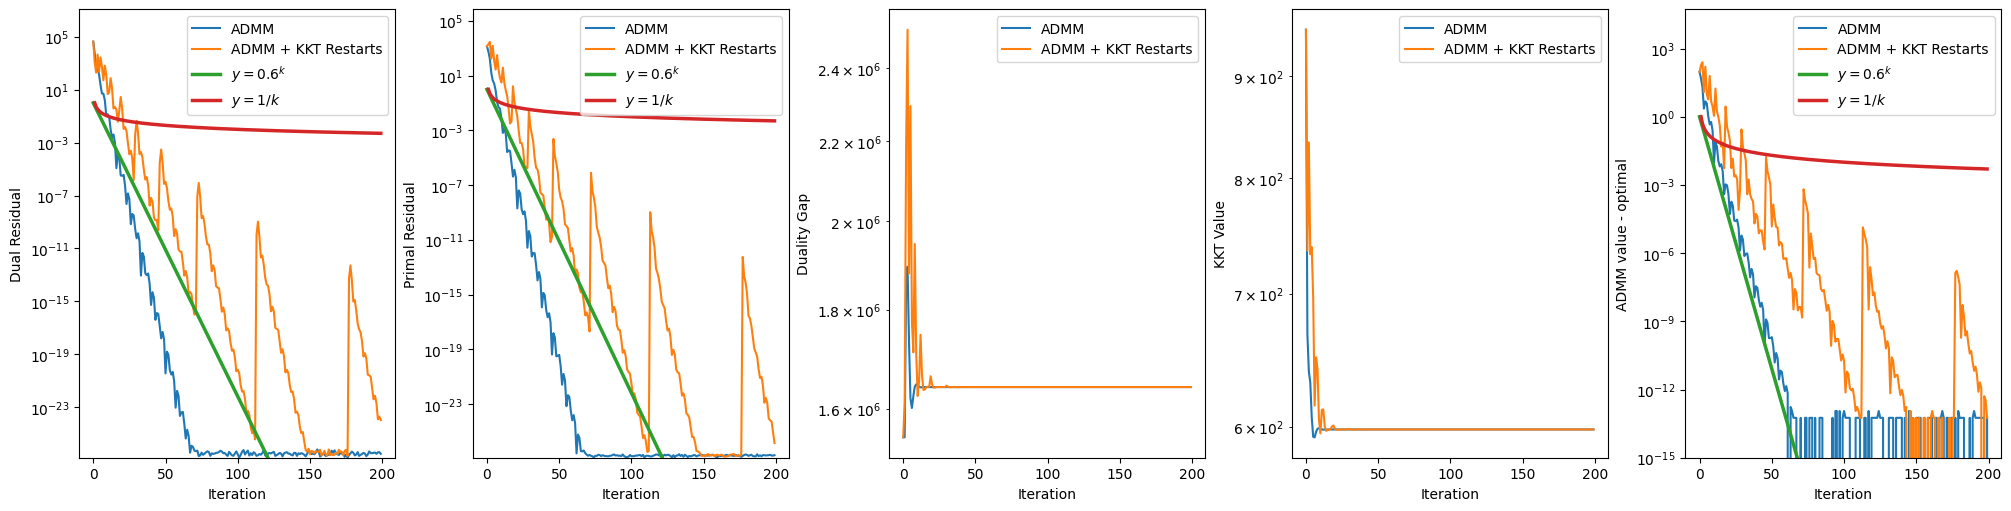

In [212]:
fig, ax = plt.subplots(1, 5, figsize=(20,5), constrained_layout=True)

# NOTE
# ADMM

ax[0].plot(dual_residual, label='ADMM')
ax[0].set_yscale('log')
ax[0].set_ylabel('Dual Residual')
ax[0].set_xlabel('Iteration')
ax[0].legend()

ax[1].plot(primal_residual, label='ADMM')
ax[1].set_yscale('log')
ax[1].set_ylabel('Primal Residual')
ax[1].set_xlabel('Iteration')
ax[1].legend()

ax[2].plot(duality_gap, label='ADMM')
ax[2].set_yscale('log')
ax[2].set_ylabel('Duality Gap')
ax[2].set_xlabel('Iteration')
ax[2].legend()

ax[3].plot(KKT_valus, label='ADMM')
ax[3].set_yscale('log')
ax[3].set_ylabel('KKT Value')
ax[3].set_xlabel('Iteration')
ax[3].legend()

ax[4].plot(value_ADMM, label='ADMM')
ax[4].set_yscale('log')
ax[4].set_ylabel('ADMM value - optimal')
ax[4].set_xlabel('Iteration')
ax[4].legend()


# NOTE
# ADMM + KKT Restarts

ax[0].plot(dual_residual_rest, label='ADMM + KKT Restarts')
ax[0].set_yscale('log')
ax[0].set_ylabel('Dual Residual')
ax[0].set_xlabel('Iteration')
ax[0].legend()

ax[1].plot(primal_residual_rest, label='ADMM + KKT Restarts')
ax[1].set_yscale('log')
ax[1].set_ylabel('Primal Residual')
ax[1].set_xlabel('Iteration')
ax[1].legend()

ax[2].plot(duality_gap_res, label='ADMM + KKT Restarts')
ax[2].set_yscale('log')
ax[2].set_ylabel('Duality Gap')
ax[2].set_xlabel('Iteration')
ax[2].legend()

ax[3].plot(KKT_valus_rest, label='ADMM + KKT Restarts')
ax[3].set_yscale('log')
ax[3].set_ylabel('KKT Value')
ax[3].set_xlabel('Iteration')
ax[3].legend()

ax[4].plot(value_ADMM_restarts, label='ADMM + KKT Restarts')
ax[4].set_yscale('log')
ax[4].set_ylabel('ADMM value - optimal')
ax[4].set_xlabel('Iteration')
ax[4].legend()

# Plot against a linear convergence
k_value = np.arange(0, 200, 1)
y_value = 0.6 ** k_value

ax[0].plot(y_value, label=r"$y=0.6^k$", linewidth=2.5)
ax[0].legend()

ax[1].plot(y_value, label=r"$y=0.6^k$", linewidth=2.5)
ax[1].legend()

# ax[2].plot(y_value, label=r"$y=0.6^k$", linewidth=2.5)
# ax[2].legend()

# ax[3].plot(y_value, label=r"$y=0.6^k$", linewidth=2.5)
# ax[3].legend()

ax[4].plot(y_value, label=r"$y=0.6^k$", linewidth=2.5)
ax[4].legend()

# Plot against a sublinear convergence
k_value = np.arange(0, 200, 1)
y_value = 1 / k_value

ax[0].plot(y_value, label=r"$y=1/k$", linewidth=2.5)
ax[0].legend()

ax[1].plot(y_value, label=r"$y=1/k$", linewidth=2.5)
ax[1].legend()

# ax[2].plot(y_value, label=r"$y=1/k$", linewidth=2.5)
# ax[2].legend()

# ax[3].plot(y_value, label=r"$y=1/k$", linewidth=2.5)
# ax[3].legend()

ax[4].plot(y_value, label=r"$y=1/k$", linewidth=2.5)
ax[4].legend()


# Setting the y-axis limit for visual convinience
ax[0].set_ylim(min(dual_residual))
ax[1].set_ylim(min(primal_residual))
ax[2].set_ylim(0)
# ax[3].set_ylim(min(KKT_valus))
ax[4].set_ylim(1e-15)